## Data Import

In [1]:
import pandas as pd

# Define the file paths (adjust the paths if the files are in a different location)
fake_file_path = 'Data/Fake.csv'
true_file_path = 'Data/True.csv'

# Read the CSV files into dataframes
# Specify the columns to use to avoid extra unnamed columns
columns_to_use = ['title', 'text', 'subject', 'date']

fake_df = pd.read_csv(fake_file_path, usecols=columns_to_use, quotechar='"', delimiter=',')
true_df = pd.read_csv(true_file_path, usecols=columns_to_use, quotechar='"', delimiter=',')

# Add the isTrue column
fake_df['isTrue'] = 0  # Fake news labeled as 0
true_df['isTrue'] = 1  # True news labeled as 1

# Combine the dataframes
news_df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the combined dataframe
news_df = news_df.sample(frac=1).reset_index(drop=True)


# Specify the target subjects
target_subjects = [
    'politicsNews',
    'worldnews',
    'News',
    'politics',
    'left-news',
    'Government News',
    'US_News',
    'Middle-east'
]

# Filter the dataframe to include only rows with the target subjects
news_df = news_df[news_df['subject'].isin(target_subjects)]

 

# # Display the first few rows of each dataframe to verify the contents
# print("Fake News Dataframe:")
# print(fake_df.head())  # Display the first 5 rows of the fake news dataframe

# print("\nTrue News Dataframe:")
# print(true_df.head())  # Display the first 5 rows of the true news dataframe
news_df #.head(55)

,title,text,subject,date,isTrue
0,"Uzbek dissident released from jail, still face...",TASHKENT (Reuters) - Uzbek police released dis...,worldnews,"October 1, 2017",1
1,‘We’re Just Not Into Her’ – Hillary Clinton Lo...,Patrick Henningsen 21st Century WireWhat s up...,US_News,17-Sep-16,0
2,Republican plan to repeal Obamacare would leav...,"(In March 13 item, corrects paragraph 7 to sh...",politicsNews,"March 13, 2017",1
3,"Youngstown, Ohio, mayor gets probation in corr...","CLEVELAND (Reuters) - The mayor of Youngstown,...",politicsNews,"March 28, 2016",1
4,INCREDIBLE! Vietnam Veteran Cries on President...,President Trump hits it out of the park! He ju...,politics,11-Nov-17,0
...,...,...,...,...,...
44914,Republican Governor Refuses Medicaid Expansio...,"Is it utter contempt, or incredible stupidity?...",News,30-Mar-16,0
44915,Prosecutor links suspect arrested last week ne...,PARIS (Reuters) - A French prosecutor said on ...,worldnews,"September 10, 2017",1
44916,Trump gives Boy Scouts at jamboree a taste of ...,"GLEN JEAN, West Virginia (Reuters) - After ano...",politicsNews,"July 25, 2017",1
44917,BOMBSHELL: Trump Called ‘The Apprentice’ Soun...,A microphone guy who worked on The Apprentice ...,News,11-Oct-16,0


## Federated Leanrning 

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)  # Limit features to manage memory usage
X = vectorizer.fit_transform(news_df['text'])
y = news_df['isTrue'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple neural network that can handle sparse input
class SparseNewsClassifier(nn.Module):
    def __init__(self, input_size):
        super(SparseNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Helper function to convert sparse matrices to dense format for PyTorch
def sparse_to_torch(sparse_matrix):
    return torch.FloatTensor(sparse_matrix.toarray())

# Hyperparameters
num_clients = 4
num_rounds = 5 #test  5
local_epochs = 5 #test 2
batch_size = 2
learning_rate = 0.01



# Function to simulate local training on client data
def train_local_model(client_data, client_labels, model, epochs, batch_size, test_data, test_labels):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    dataset = torch.utils.data.TensorDataset(sparse_to_torch(client_data), torch.tensor(client_labels, dtype=torch.float32).unsqueeze(1))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    accuracies = []
    for epoch in range(epochs):
        for data, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            predictions = model(test_data)
            predicted_labels = (predictions >= 0.5).float()
            accuracy = accuracy_score(test_labels.numpy(), predicted_labels.numpy())
            accuracies.append(accuracy*100.0)
        model.train()  # Switch back to training mode
    return model.state_dict(),accuracies

# Function to aggregate weights from multiple clients
def aggregate_weights(global_model, client_weights):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_weights[i][key] for i in range(len(client_weights))], dim=0).mean(dim=0)
    global_model.load_state_dict(global_dict)
    return global_model

# Federated learning process
input_size = X_train.shape[1]
global_model = SparseNewsClassifier(input_size)

######
test_data = sparse_to_torch(X_test)
test_labels = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
# Summarize history for accuracy
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
accuracyplot =dict()
######

for round_num in range(num_rounds):
    print(f"Round {round_num+1}/{num_rounds}")
    client_weights = []
    
    for client in range(num_clients):
        print(f"Client {client+1}/{num_clients}")
        
        # Split the training data among clients
        client_data = X_train[client::num_clients]
        client_labels = y_train[client::num_clients]
        
        # Initialize a local model
        local_model = SparseNewsClassifier(input_size)
        local_model.load_state_dict(global_model.state_dict())
        
        # Train the local model
        local_weights,flAccuracy = train_local_model(client_data, client_labels, local_model, local_epochs, batch_size,test_data,test_labels)
        client_weights.append(local_weights)
        
        # Plot the accuracy over epochs
        accuracyplot['Client: '+ str(client)+ ' Round:'+ str(round_num) +' Train Accuracy']=flAccuracy
        #plt.plot(range(1, local_epochs + 1), flAccuracy, marker='o', linestyle='-', color='b'  , label='Client: '+ str(client)+ ' Round:'+ str(round_num) +' Train Accuracy')
 
    
    # Aggregate weights
    global_model = aggregate_weights(global_model, client_weights)


#Evaluate the global model on test data
global_model.eval()
with torch.no_grad():
    test_data = sparse_to_torch(X_test)
    test_labels = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    predictions = global_model(test_data)
    predicted_labels = (predictions >= 0.5).float()
    accuracy = accuracy_score(test_labels.numpy(), predicted_labels.numpy())
    print(f"Test Accuracy: {accuracy*100.0}")



Round 1/5
Client 1/4
Client 2/4
Client 3/4
Client 4/4
Round 2/5
Client 1/4
Client 2/4
Client 3/4
Client 4/4
Round 3/5
Client 1/4
Client 2/4
Client 3/4
Client 4/4
Round 4/5
Client 1/4
Client 2/4
Client 3/4
Client 4/4
Round 5/5
Client 1/4
Client 2/4
Client 3/4
Client 4/4
Test Accuracy: 99.06417112299465


## Standalone Model (Not Federated)

In [4]:
# Function to simulate standalone training on client data
def train_standalone_model1(client_data, client_labels, model, epochs, batch_size, test_data, test_labels):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    dataset = torch.utils.data.TensorDataset(sparse_to_torch(client_data), torch.tensor(client_labels, dtype=torch.float32).unsqueeze(1))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    accuracies = []
    for epoch in range(epochs):
        for data, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            predictions = model(test_data)
            predicted_labels = (predictions >= 0.5).float()
            accuracy = accuracy_score(test_labels.numpy(), predicted_labels.numpy())
            accuracies.append(accuracy*100.0)
        model.train()  # Switch back to training mode
    
    return model, accuracies
# Split the training data among clients
client_data = X_train 
client_labels = y_train

# Initialize a local model
stand_alone_model1 = SparseNewsClassifier(input_size)
# stand_alone_model1.load_state_dict(stand_alone_model1.state_dict())

test_data = sparse_to_torch(X_test)
test_labels = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Train the local model and track accuracies
stand_alone_model1, accuracies = train_standalone_model1(client_data, client_labels, stand_alone_model1, local_epochs, batch_size,test_data,test_labels)
 
print('Start Stand Alone')


predictions = stand_alone_model1(test_data)
predicted_labels = (predictions >= 0.5).float()
accuracy = accuracy_score(test_labels.numpy(), predicted_labels.numpy())
print(f"Test Accuracy: {accuracy*100.0}")
print('End Stand Alone')




# Print the final accuracy
final_accuracy = accuracies[-1]
print(f"Final Test Accuracy: {final_accuracy}")

 


Start Stand Alone
Test Accuracy: 99.1421568627451
End Stand Alone
Final Test Accuracy: 99.1421568627451


## Chart comparison Federated Vs Standalone

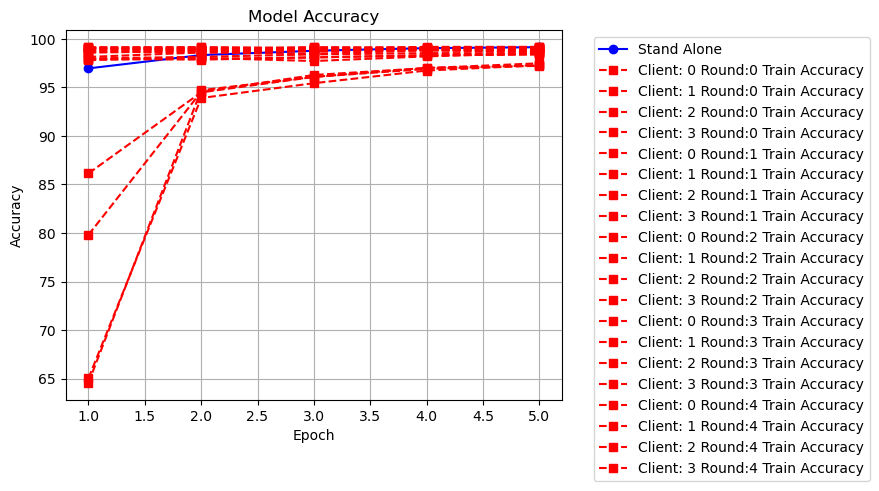

In [5]:
# Plot the accuracy over epochs
plt.plot(range(1, local_epochs + 1), accuracies, marker='o', linestyle='-', color='b' ,label='Stand Alone')
# plt.title('Model Accuracy Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.show()

# accuracyplot['Client: '+ str(client)+ ' Round:'+ str(round_num) +' Train Accuracy']=flAccuracy
for key in accuracyplot:
    plt.plot(range(1, local_epochs + 1), accuracyplot[key], marker='s', linestyle='--', color='r'  , label=key)
    

plt.title('Model Accuracy')
# Configuring the legend to be outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(loc='upper left')      
plt.grid(True)
plt.show()

## Confusion Matrix For Federated Learning

Confusion Matrix:
[[4663   37]
 [  47 4229]]


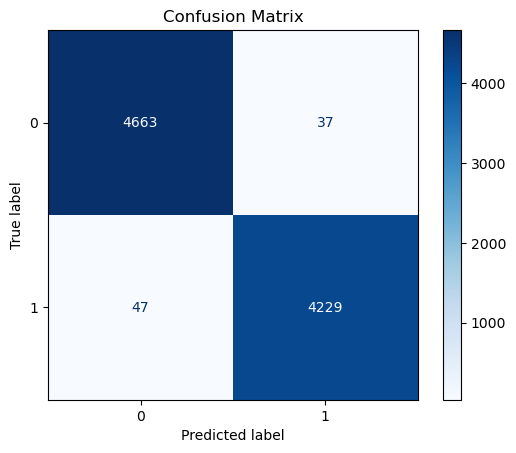

Test Accuracy: 0.9906417112299465


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the global model on test data
global_model.eval()
with torch.no_grad():
    test_data = sparse_to_torch(X_test)
    test_labels = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    predictions = global_model(test_data)
    predicted_labels = (predictions >= 0.5).float()
    
    # Convert tensors to numpy arrays for compatibility with scikit-learn functions
    true_labels_np = test_labels.numpy()
    predicted_labels_np = predicted_labels.numpy()
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels_np, predicted_labels_np)
    
    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Print accuracy for reference
accuracy = accuracy_score(true_labels_np, predicted_labels_np)
print(f"Test Accuracy: {accuracy}")
